<a href="https://www.kaggle.com/code/adityarai12/alzheimer-disease-prediction-ensemble-model?scriptVersionId=189412359" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout
from sklearn.metrics import accuracy_score



/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
import ipywidgets as widgets
import io
from PIL import Image
import tqdm
from sklearn.model_selection import train_test_split
import cv2
from sklearn.utils import shuffle
import tensorflow as tf

STATE PATH AND RESIZE IMAGES

In [4]:
X_train = []
Y_train = []
image_size = 150
labels = ['MildDemented','ModerateDemented','NonDemented','VeryMildDemented']
for i in labels:
    folderPath = os.path.join('/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train',i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        Y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test',i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        Y_train.append(i)
        
X_train = np.array(X_train)
Y_train = np.array(Y_train)


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,  # Random rotation by up to 10 degrees
    width_shift_range=0.1,  # Random horizontal shift by up to 10%
    height_shift_range=0.1,  # Random vertical shift by up to 10%
    shear_range=0.2,  # Shear angle in counter-clockwise direction
    zoom_range=0.2,  # Random zoom by up to 20%
    horizontal_flip=True,  # Random horizontal flip
    fill_mode='nearest'  # Fill mode for points outside the input boundaries
)

# Reshape the input data to (num_samples, height, width, channels)
X_train = X_train.reshape(-1, image_size, image_size, 3)

# Apply data augmentation
augmented_data = []
for img in X_train:
    # Reshape the image to (1, height, width, channels) for flow method
    img = img.reshape((1,) + img.shape)
    # Generate augmented images
    augmented_images = datagen.flow(img, batch_size=1)
    # Append augmented images to the list
    for _ in range(5):  # Augment each image 5 times
        augmented_data.append(augmented_images.next()[0])

# Concatenate original and augmented data
X_train_augmented = np.concatenate([X_train, augmented_data], axis=0)
Y_train_augmented = np.concatenate([Y_train] * 6, axis=0)  # Multiply by 6 to match the augmented data


In [6]:
X_train , Y_train = shuffle(X_train, Y_train, random_state = 101)
X_train.shape
# X_train_augmented.shape

(6400, 150, 150, 3)

In [7]:
X_train , X_test , y_train , y_test = train_test_split(X_train,Y_train, test_size=0.1 , random_state=101)

In [8]:
Y_train_augmented


array(['MildDemented', 'MildDemented', 'MildDemented', ...,
       'VeryMildDemented', 'VeryMildDemented', 'VeryMildDemented'],
      dtype='<U16')

COVERSION OF STATES TO INDEX

In [9]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

CONVOLUTIONAL NEURAL NETWORK

RESNET ARCHITECTURE

In [10]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load pre-trained ResNet50 model
resnet_model = ResNet50(include_top=False, weights='imagenet', input_shape=(150, 150, 3))

# Freeze the layers of the pre-trained model
for layer in resnet_model.layers:
    layer.trainable = False

# Create a new model
res_model = Sequential()

# Add the pre-trained ResNet50 model as the first layer
res_model.add(resnet_model)

# Add additional layers
res_model.add(Flatten())
res_model.add(Dense(256, activation='relu'))
res_model.add(BatchNormalization())
res_model.add(Dropout(0.5))
res_model.add(Dense(256, activation='relu'))
res_model.add(BatchNormalization())
res_model.add(Dropout(0.5))
res_model.add(Dense(4, activation='softmax'))

# Apply data augmentation
data_generator = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Compile the model
res_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

# Train the model with data augmentation
final1 = res_model.fit(
                  X_train,y_train,  
                 epochs=10,
                  batch_size=32,
                  validation_split=0.1
)




94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/10
162/162 [==============================] - 16s 43ms/step - loss: 1.5265 - accuracy: 0.4628 - val_loss: 0.8319 - val_accuracy: 0.6493
Epoch 2/10
162/162 [==============================] - 6s 36ms/step - loss: 1.0463 - accuracy: 0.5914 - val_loss: 0.8576 - val_accuracy: 0.6372
Epoch 3/10
162/162 [==============================] - 6s 36ms/step - loss: 0.7765 - accuracy: 0.6861 - val_loss: 0.6895 - val_accuracy: 0.7066
Epoch 4/10
162/162 [==============================] - 6s 35ms/step - loss: 0.6191 - accuracy: 0.7502 - val_loss: 0.9523 - val_accuracy: 0.6094
Epoch 5/10
162/162 [==============================] - 6s 35ms/step - loss: 0.5092 - accuracy: 0.8025 - val_loss: 0.4550 - val_accuracy: 0.8073
Epoch 6/10
162/162 [==============================] - 6s 36ms/step - loss: 0.4154 - accuracy: 0.8412 - val_loss: 0.4361 - val_accuracy: 0.8316
Epoch 7/10
162/162 [==============================] - 6s 35ms/step - loss: 0

DENSENET ARCHITECTURE


In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load pre-trained DenseNet121 model
densenet_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(150, 150, 3))

# Freeze the layers of the pre-trained model
for layer in densenet_model.layers:
    layer.trainable = False

# Create a new model
ensenet_model= Sequential()

# Add the pre-trained DenseNet121 model as the first layer
ensenet_model.add(densenet_model)

# Add additional layers
ensenet_model.add(Flatten())
ensenet_model.add(Dense(256, activation='relu'))
ensenet_model.add(BatchNormalization())
ensenet_model.add(Dropout(0.5))
ensenet_model.add(Dense(256, activation='relu'))
ensenet_model.add(BatchNormalization())
ensenet_model.add(Dropout(0.5))
ensenet_model.add(Dense(4, activation='softmax'))

# # Apply data augmentation
# data_generator = ImageDataGenerator(
#     rotation_range=10,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# Compile the model
ensenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

# Train the model with data augmentation
final2 = ensenet_model.fit(
    X_train, y_train,  # Replace with your training data
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping]
)


29084464/29084464 [==============================] - 0s 0us/step
Epoch 1/10
162/162 [==============================] - 17s 50ms/step - loss: 1.4984 - accuracy: 0.4655 - val_loss: 0.9733 - val_accuracy: 0.5903
Epoch 2/10
162/162 [==============================] - 6s 35ms/step - loss: 1.0986 - accuracy: 0.5529 - val_loss: 0.8150 - val_accuracy: 0.6372
Epoch 3/10
162/162 [==============================] - 6s 34ms/step - loss: 0.9104 - accuracy: 0.6142 - val_loss: 0.9482 - val_accuracy: 0.5833
Epoch 4/10
162/162 [==============================] - 6s 35ms/step - loss: 0.8067 - accuracy: 0.6582 - val_loss: 0.7549 - val_accuracy: 0.7222
Epoch 5/10
162/162 [==============================] - 6s 35ms/step - loss: 0.7187 - accuracy: 0.6987 - val_loss: 0.7326 - val_accuracy: 0.6840
Epoch 6/10
162/162 [==============================] - 6s 34ms/step - loss: 0.6789 - accuracy: 0.7112 - val_loss: 0.8227 - val_accuracy: 0.6094
Epoch 7/10
162/162 [==============================] - 6s 35ms/step - loss: 0

MOBILENET ARCHITECTURE

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load pre-trained MobileNetV2 model
mobilenet_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(150, 150, 3))

# Freeze the layers of the pre-trained model
for layer in mobilenet_model.layers:
    layer.trainable = False

# Create a new model
e_model = Sequential()

# Add the pre-trained MobileNetV2 model as the first layer
e_model.add(mobilenet_model)

# Add additional layers
e_model.add(Flatten())
e_model.add(Dense(256, activation='relu'))
e_model.add(BatchNormalization())
e_model.add(Dropout(0.5))
e_model.add(Dense(256, activation='relu'))
e_model.add(BatchNormalization())
e_model.add(Dropout(0.5))
e_model.add(Dense(4, activation='softmax'))

# Compile the model
e_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

# Train the model with data augmentation
final_mob = e_model.fit(
    X_train, y_train,  # Replace with your training data
    epochs=15,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping]
)


9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/15
162/162 [==============================] - 9s 25ms/step - loss: 1.5673 - accuracy: 0.4412 - val_loss: 1.1782 - val_accuracy: 0.5365
Epoch 2/15
162/162 [==============================] - 3s 18ms/step - loss: 1.1517 - accuracy: 0.5334 - val_loss: 0.8666 - val_accuracy: 0.6163
Epoch 3/15
162/162 [==============================] - 3s 17ms/step - loss: 0.9703 - accuracy: 0.5691 - val_loss: 0.8862 - val_accuracy: 0.6198
Epoch 4/15
162/162 [==============================] - 3s 18ms/step - loss: 0.8775 - accuracy: 0.6111 - val_loss: 0.8378 - val_accuracy: 0.6250
Epoch 5/15
162/162 [==============================] - 3s 18ms/step - loss: 0.8160 - accuracy: 0.6362 - val_loss: 0.8184 - val_accuracy: 0.6510
Epoch 6/15
162/162 [==============================] - 3s 17ms/step - loss: 0.7740 - accuracy: 0.6516 - val_loss: 0.8258 - val_accuracy: 0.6337
Epoch 7/15
162/162 [==============================] - 3s 17ms/step - loss: 0.72

In [13]:
from tensorflow.keras.models import Model

# Get the output tensors of both models
resnet_output = res_model.layers[-1].output
densenet_output = ensenet_model.layers[-1].output
mobilenet_output = e_model.layers[-1].output

# Average the predictions from both models
ensemble_output = tf.keras.layers.average([resnet_output, densenet_output, mobilenet_output])

# Create the ensemble model
ensemble_model = Model(inputs=[res_model.input, ensenet_model.input, e_model.input], outputs=ensemble_output)


ENSEMBLE MODEL PERFORMANCE

In [14]:
# Assuming you have test data: X_test and y_test

# Compile the ensemble model
ensemble_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Evaluate the ensemble model on test data
_, accuracy = ensemble_model.evaluate([X_test, X_test, X_test], y_test)  # Assuming you have X_test and y_test

print("Ensemble Model Accuracy:", accuracy)


20/20 [==============================] - 8s 72ms/step - loss: 0.4262 - accuracy: 0.8938
Ensemble Model Accuracy: 0.893750011920929


In [15]:
from sklearn.metrics import confusion_matrix, classification_report

# Assuming you have test data: X_test and y_test

# Predictions of individual models
resnet_predictions = res_model.predict(X_test)
densenet_predictions = ensenet_model.predict(X_test)
mobilenet_predictions = e_model.predict(X_test)

# Ensemble predictions
ensemble_predictions = ensemble_model.predict([X_test, X_test, X_test])

# Convert predictions to class labels
resnet_labels = np.argmax(resnet_predictions, axis=1)
densenet_labels = np.argmax(densenet_predictions, axis=1)
mobilenet_labels = np.argmax(mobilenet_predictions, axis=1)
ensemble_labels = np.argmax(ensemble_predictions, axis=1)

# Convert true labels to class labels
y_true_labels = np.argmax(y_test, axis=1)

# Confusion matrix for individual models
resnet_cm = confusion_matrix(y_true_labels, resnet_labels)
densenet_cm = confusion_matrix(y_true_labels, densenet_labels)
mobilenet_cm = confusion_matrix(y_true_labels, mobilenet_labels)

# Confusion matrix for ensemble model
ensemble_cm = confusion_matrix(y_true_labels, ensemble_labels)

# Classification report for individual models
print("ResNet Classification Report:")
print(classification_report(y_true_labels, resnet_labels, target_names=labels))

print("DenseNet Classification Report:")
print(classification_report(y_true_labels, densenet_labels, target_names=labels))

print("MobileNet Classification Report:")
print(classification_report(y_true_labels, mobilenet_labels, target_names=labels))

# Classification report for ensemble model
print("Ensemble Model Classification Report:")
print(classification_report(y_true_labels, ensemble_labels, target_names=labels))

from sklearn.metrics import accuracy_score

# Calculate accuracy score for each class
resnet_accuracy = accuracy_score(y_true_labels, resnet_labels)
densenet_accuracy = accuracy_score(y_true_labels, densenet_labels)
mobilenet_accuracy = accuracy_score(y_true_labels, mobilenet_labels)
ensemble_accuracy = accuracy_score(y_true_labels, ensemble_labels)

print("ResNet Accuracy:", resnet_accuracy)
print("DenseNet Accuracy:", densenet_accuracy)
print("MobileNet Accuracy:", mobilenet_accuracy)
print("Ensemble Model Accuracy:", ensemble_accuracy)


20/20 [==============================] - 6s 70ms/step
ResNet Classification Report:
                  precision    recall  f1-score   support

    MildDemented       0.61      0.97      0.75        94
ModerateDemented       1.00      1.00      1.00         7
     NonDemented       0.99      0.74      0.85       319
VeryMildDemented       0.77      0.86      0.81       220

        accuracy                           0.82       640
       macro avg       0.84      0.89      0.85       640
    weighted avg       0.86      0.82      0.82       640

DenseNet Classification Report:
                  precision    recall  f1-score   support

    MildDemented       0.52      0.90      0.66        94
ModerateDemented       0.83      0.71      0.77         7
     NonDemented       0.78      0.91      0.84       319
VeryMildDemented       0.90      0.40      0.55       220

        accuracy                           0.73       640
       macro avg       0.76      0.73      0.70       640
    weigh

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

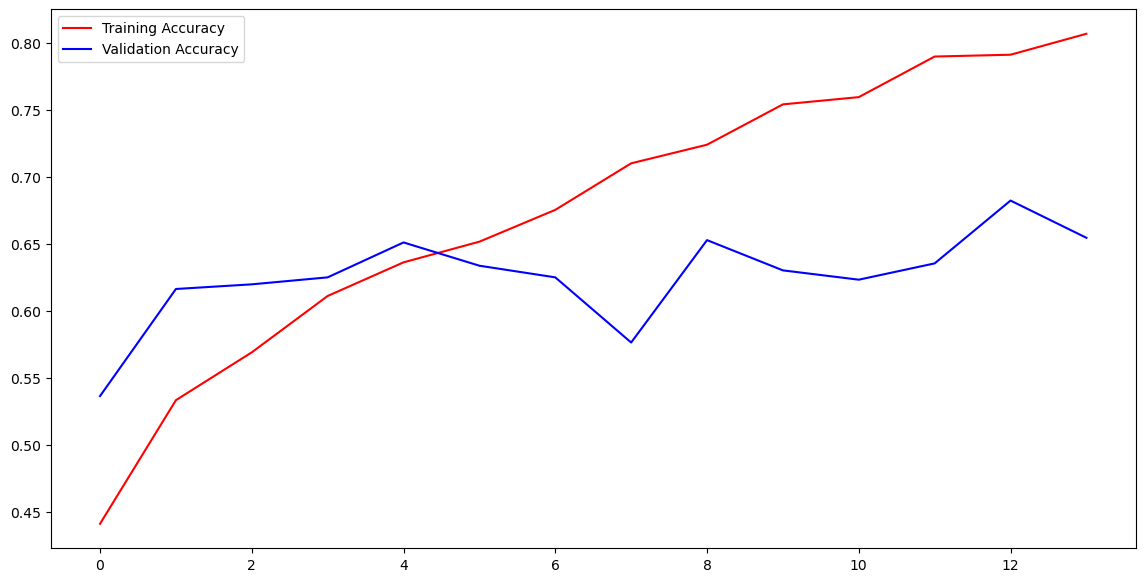

In [17]:
acc = final_mob.history['accuracy']
val_acc = final_mob.history['val_accuracy']
epochs = range(len(acc))
fig = plt.figure(figsize=(14,7))
plt.plot(epochs,acc,'r',label="Training Accuracy")
plt.plot(epochs,val_acc,'b',label="Validation Accuracy")
plt.legend(loc='upper left')
plt.show()

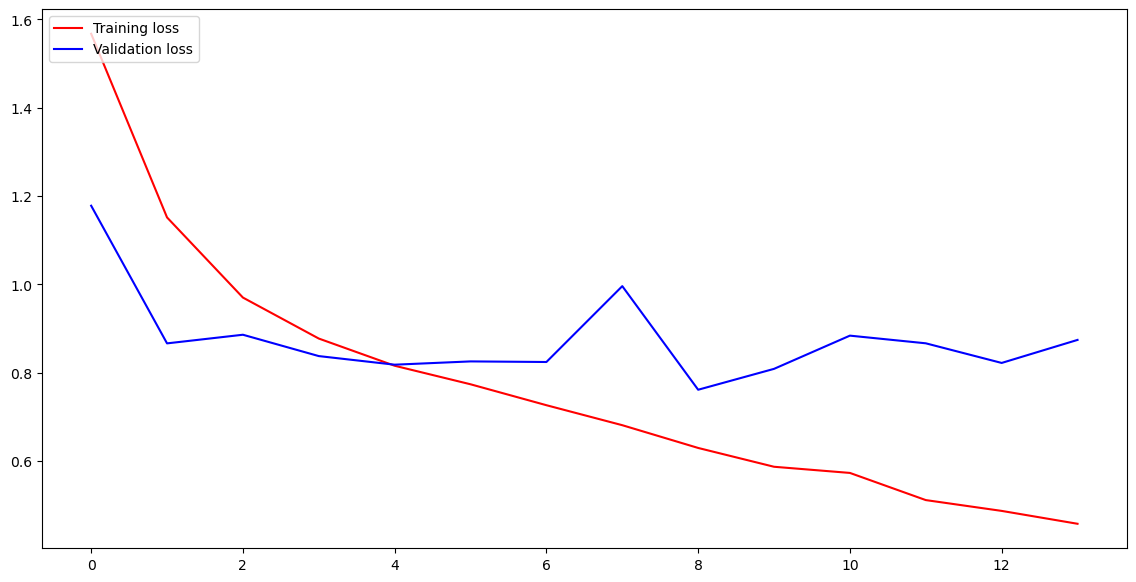

In [18]:
loss = final_mob.history['loss']
val_loss = final_mob.history['val_loss']
epochs = range(len(loss))
fig = plt.figure(figsize=(14,7))
plt.plot(epochs,loss,'r',label="Training loss")
plt.plot(epochs,val_loss,'b',label="Validation loss")
plt.legend(loc='upper left')
plt.show()

In [19]:
img = cv2.imread('/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/MildDemented/26 (19).jpg')
img = cv2.resize(img,(150,150))
img_array = np.array(img)
img_array.shape

(150, 150, 3)

In [20]:
img_array = img_array.reshape(1,150,150,3)
img_array.shape

(1, 150, 150, 3)

Example Prediction

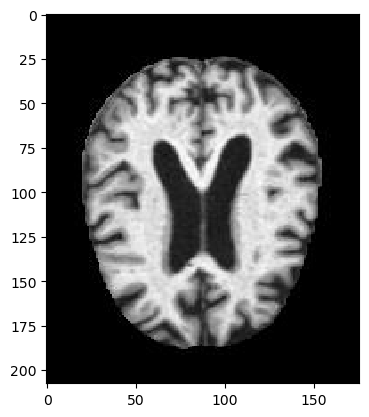

In [21]:
from tensorflow.keras.preprocessing import image
img = image.load_img('/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/MildDemented/26 (19).jpg')
plt.imshow(img,interpolation='nearest')
plt.show()